# Assignment_3_PRT565_Group 14_Sydney
Group Members:
1.   Sabbir Mahmud (s388453)
2.   Mahdee Nafis (s386290)
3.   Mohammed Mujtaba Muqtadir (s391003)

**Kubernetes Intrusion Detection with Kube IDS0 Datasets (Kaggle) — A Comparative Deleopment of AI & ML using Decision Tree, Random Forest, Naïve Bayes, and MLP by Accuracy, Precision, Recall, and F1**

`Models: Decision Tree, Random Forest, Naïve Bayes, ANN (MLP)`

`Metrics: Accuracy, Precision, Recall, F1 (macro)`

**Topic: Deveolp AI using Kubernetes Intrusion Detection with Kube IDS0 Datasets**

`The steps that we covered thorughout the assignment:`

1. Environment Setup (Sabbir and Mahdee)
2. Load the Datastes (Sabbir) (Upload the dataset from the device, not from drive)
3. Schema & data quality Check (Muqtadir)
4. Transformation & Processing (Mahdee)
5. Cleaning and Standardization (Sabbir)
6. Feature Engineering (Muqtadir)
7. Final analytic dataset & safety checks (Sabbir and Mahdee)
8. Models and Evaluation (Sabbir, Mahdee and Muqtadir)

* 8.1 Decision Tree (evaluated) + shallow tree (visual) (Sabbir)
* 8.2 Random Forest with Feature Importance Plot (Mahdee)
* 8.3 Naive Bias (Muqtadir)

9. ANN (MLP) (Mahdee)
10. Model Summary (Sabbir)
11. Deep Learning and Multilayer ANN (Sabbir and Muqtadir)
12. Advance Deep Learning
13. Result Comparison (Mahdee)

# 1. ENVIRONMENT SETUP (Sabbir and Mahdee)


In [35]:
!pip -q install scikit-learn==1.4.2 imbalanced-learn==0.12.2 --upgrade

**Import essential libraries to develop the models**

In [36]:
import os, math, re
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# 2. Load Data (Sabbir)

**Upload four datasets from the computer (Do not upload in the drive)**

Expect these 4 CSVs in the runtime. If missing in Colab, you'll be prompted to upload from the device.

In [37]:
file_map = {
    "slowloris": "benign+slowloris_container_metrics.csv",
    "torshammer": "benign+torshammer_container_metrics.csv",
    "dos_bf": "benign+dos-s+dos-t+bf_container_metrics.csv",
    "sqli": "benign+sqli_container_metrics.csv",
}

missing = [fn for fn in file_map.values() if not os.path.exists(fn)]
if missing:
    try:
        from google.colab import files  # type: ignore
        print("Please upload these files now:\n", missing)
        files.upload()
    except Exception as e:
        print("Upload helper not available. Ensure files exist:", missing)

raw_dfs = []
for scenario, fname in file_map.items():
    if not os.path.exists(fname):
        raise FileNotFoundError(f"Could not find required file: {fname}")
    df = pd.read_csv(fname)
    df["__scenario__"] = scenario
    # Normalize timestamp if present
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    raw_dfs.append(df)

print("\nLoaded files:")
for d in raw_dfs:
    print(f"  - {d['__scenario__'].iat[0]} shape: {d.shape}")


Loaded files:
  - slowloris shape: (426, 355)
  - torshammer shape: (906, 355)
  - dos_bf shape: (1446, 91)
  - sqli shape: (291, 91)


# 3. SCHEMA & DATA QUALITY CHECK (Muqtadir)
Instead of intersection (which was empty), we build the UNION of numeric columns,
then later drop columns with too many missing values and zero variance.

In [38]:
def numeric_union(dfs):
    union = set()
    for df in dfs:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        cols = [c for c in cols if c.lower() != "unnamed: 0"]
        union |= set(cols)
    return sorted(list(union))

all_numeric = numeric_union(raw_dfs)
print(f"\nNumeric feature UNION across files: {len(all_numeric)} columns")

# Quick quality snapshot per file over UNION columns (NaNs expected; we'll handle them later)
def quick_quality(df, name, cols):
    present = [c for c in cols if c in df.columns]
    null_ratio = df[present].isna().mean().mean() if present else 1.0
    # std after filling NaNs with medians to approximate zero variance
    if present:
        tmp = df[present].copy()
        tmp = tmp.fillna(tmp.median(numeric_only=True))
        zero_var = (tmp.std(numeric_only=True) == 0).sum()
    else:
        zero_var = len(cols)
    print(f"  {name}: rows={len(df)}, present_features={len(present)}, "
          f"avg_null_ratio={null_ratio:.3f}, approx_zero_var_cols={zero_var}")

for df in raw_dfs:
    quick_quality(df, df["__scenario__"].iat[0], all_numeric)



Numeric feature UNION across files: 440 columns
  slowloris: rows=426, present_features=352, avg_null_ratio=0.011, approx_zero_var_cols=217
  torshammer: rows=906, present_features=352, avg_null_ratio=0.011, approx_zero_var_cols=206
  dos_bf: rows=1446, present_features=88, avg_null_ratio=0.068, approx_zero_var_cols=47
  sqli: rows=291, present_features=88, avg_null_ratio=0.068, approx_zero_var_cols=48


# 4. TRANSFORMATION & PREPROCESSING (Mahdee)

Reindex each DF to the UNION schema so concatenation aligns columns.

In [39]:
base_cols = ["__scenario__"]
if any("timestamp" in d.columns for d in raw_dfs):
    base_cols = ["timestamp"] + base_cols

dfs_reindexed = []
for df in raw_dfs:
    cols = base_cols + all_numeric
    # Create any missing numeric columns as NaN
    re_df = pd.DataFrame(columns=cols)
    # Fill what we have
    for c in cols:
        if c in df.columns:
            re_df[c] = df[c]
    # Ensure correct dtypes
    if "timestamp" in re_df.columns:
        re_df["timestamp"] = pd.to_datetime(re_df["timestamp"], errors="coerce")
    dfs_reindexed.append(re_df)

full = pd.concat(dfs_reindexed, ignore_index=True)
print("\nAfter reindex & concat:", full.shape)

/tmp/ipython-input-973046997.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full = pd.concat(dfs_reindexed, ignore_index=True)



After reindex & concat: (3069, 442)


# 5. CLEANING & STANDARDISATION (Sabbir)

In [40]:
# 5.1 Drop features with >60% missing globally (tunable)
numeric_feats = all_numeric.copy()
missing_frac = full[numeric_feats].isna().mean()
keep_feats = [c for c in numeric_feats if missing_frac[c] <= 0.60]
dropped_missing = sorted(set(numeric_feats) - set(keep_feats))
print(f"Dropped for >60% missing: {len(dropped_missing)}")

# 5.2 Impute temporarily to identify zero-variance columns; then drop them
tmp = full[keep_feats].copy()
tmp = tmp.fillna(tmp.median(numeric_only=True))
stds = tmp.std(numeric_only=True)
keep_feats = [c for c in keep_feats if stds[c] > 0]
print(f"Remaining features after zero-variance filter: {len(keep_feats)}")

# Guard: if still empty, pick top-K least-missing from UNION as a last resort
if len(keep_feats) == 0:
    print("WARNING: No features survived. Falling back to least-missing top-30.")
    least_missing = missing_frac.sort_values().index.tolist()[:30]
    keep_feats = least_missing

Dropped for >60% missing: 10
Remaining features after zero-variance filter: 189


# 6. FEATURE ENGINEERING (Muqtadir)

In [41]:
# Add simple first-difference features for rate/network-related columns (per scenario).
engineer_from = [c for c in keep_feats if c.endswith("_rate") or "network" in c.lower()]
engineer_from = engineer_from[:20]  # cap
full_sorted = full.sort_values(by=["__scenario__", "timestamp"] if "timestamp" in full.columns else ["__scenario__"]).copy()

eng_cols = []
for col in engineer_from:
    newc = col + "_diff"
    full_sorted[newc] = full_sorted.groupby("__scenario__")[col].diff().fillna(0)
    eng_cols.append(newc)

feat_cols = keep_feats + eng_cols
feat_cols = list(dict.fromkeys(feat_cols))  # unique, ordered

# 7. FINAL ANALYTIC DATASET & SAFETY CHECKS (Sabbir and Mahdee)

In [42]:
X = full_sorted[feat_cols].copy()
y = full_sorted["__scenario__"].copy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

# Safety
assert X.shape[1] > 0, "No features available after cleaning."
assert len(X) == len(y_enc), "Feature/label length mismatch."
assert not np.any(np.isinf(X.values)), "Found inf in X."

print("\nFinal analytic dataset")
print(f"  X shape: {X.shape}, y size: {len(y_enc)}, classes: {list(le.classes_)}")

# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)

# Common numeric pipeline
numeric_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])


Final analytic dataset
  X shape: (3069, 209), y size: 3069, classes: ['dos_bf', 'slowloris', 'sqli', 'torshammer']



# FAST CV + RANDOMIZED TUNING


In [43]:

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

def ensure_df(X):
    return pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
def ensure_arr(y):
    return np.ravel(y)

X_trn = ensure_df(X_train)
y_trn = ensure_arr(y_train)
X_tst = ensure_df(X_test)
y_tst = ensure_arr(y_test)

def make_pipe(model):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("clf", model)
    ])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average="macro")

# quick CV summary
for name, base in [
    ("DecisionTree", DecisionTreeClassifier(random_state=42, class_weight="balanced")),
    ("RandomForest", RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")),
    ("GaussianNB", GaussianNB())
]:
    pipe = make_pipe(base)
    acc = cross_val_score(pipe, X_trn, y_trn, cv=cv, scoring="accuracy", n_jobs=-1)
    f1v = cross_val_score(pipe, X_trn, y_trn, cv=cv, scoring=f1_macro, n_jobs=-1)
    print(f"{name:12s} | acc={acc.mean():.3f}±{acc.std():.3f} | F1={f1v.mean():.3f}")

# RandomizedSearch for speed
from scipy.stats import randint, uniform

param_dt = {
    "clf__max_depth": randint(4, 12),
    "clf__min_samples_split": randint(2, 8),
    "clf__min_samples_leaf": randint(1, 5)
}
rs_dt = RandomizedSearchCV(make_pipe(DecisionTreeClassifier(random_state=42, class_weight="balanced")),
                           param_distributions=param_dt, n_iter=10, scoring=f1_macro, cv=cv, n_jobs=-1, random_state=42)
rs_dt.fit(X_trn, y_trn)
print("Best DT:", rs_dt.best_params_)

param_rf = {
    "clf__n_estimators": randint(80, 150),
    "clf__max_depth": randint(5, 15),
    "clf__min_samples_leaf": randint(1, 4)
}
rs_rf = RandomizedSearchCV(make_pipe(RandomForestClassifier(random_state=42, class_weight="balanced")),
                           param_distributions=param_rf, n_iter=10, scoring=f1_macro, cv=cv, n_jobs=-1, random_state=42)
rs_rf.fit(X_trn, y_trn)
print("Best RF:", rs_rf.best_params_)

param_nb = {"clf__var_smoothing": uniform(1e-9, 1e-7)}
rs_nb = RandomizedSearchCV(make_pipe(GaussianNB()),
                           param_distributions=param_nb, n_iter=8, scoring=f1_macro, cv=cv, n_jobs=-1, random_state=42)
rs_nb.fit(X_trn, y_trn)
print("Best NB:", rs_nb.best_params_)

# evaluate tuned models on test data
def eval_plot_safe(name, y_true, y_pred, tag=None):
    try:
        # try old signature that accepts 'tag'
        return evaluate_and_plot(name, y_true, y_pred, tag)
    except TypeError:
        # fall back to current signature without 'tag'
        return evaluate_and_plot(name, y_true, y_pred)

# evaluate tuned models on test data
best_models = [
    ("DecisionTree (Tuned)", rs_dt.best_estimator_),
    ("RandomForest (Tuned)", rs_rf.best_estimator_),
    ("GaussianNB (Tuned)", rs_nb.best_estimator_)
]
for name, model in best_models:
    y_pred = model.predict(X_tst)
    tag = name.replace(" ", "_").lower()


DecisionTree | acc=0.999±0.002 | F1=0.998
RandomForest | acc=1.000±0.000 | F1=1.000
GaussianNB   | acc=0.996±0.003 | F1=0.994
Best DT: {'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 6}
Best RF: {'clf__max_depth': 11, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 94}
Best NB: {'clf__var_smoothing': np.float64(3.845401188473625e-08)}


# 8. Model and Evaluation (Sabbir, Mahdee and Muqtadir)

In [44]:
def evaluate_and_plot(name, y_true, y_pred, save_prefix):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n[{name}]")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f} (macro)")
    print(f"  Recall   : {rec:.4f} (macro)")
    print(f"  F1-score : {f1:.4f} (macro)")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=list(le.classes_), zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(le.classes_)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
    plt.figure()
    disp.plot(xticks_rotation=45, colorbar=False)
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    fig_path = f"{save_prefix}_confusion_matrix.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()
    print(f"Saved: {fig_path}")

    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

results = []

# 8.1 Decision Tree (evaluated) + shallow tree (visual) (Sabbir)

Training Decision Tree Classifier (with Imputation)...

[DecisionTreeClassifier (Imputed)]
  Accuracy : 1.0000
  Precision: 1.0000 (macro)
  Recall   : 1.0000 (macro)
  F1-score : 1.0000 (macro)

Classification report:
              precision    recall  f1-score   support

      dos_bf       1.00      1.00      1.00       290
   slowloris       1.00      1.00      1.00        85
        sqli       1.00      1.00      1.00        58
  torshammer       1.00      1.00      1.00       181

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



<Figure size 640x480 with 0 Axes>

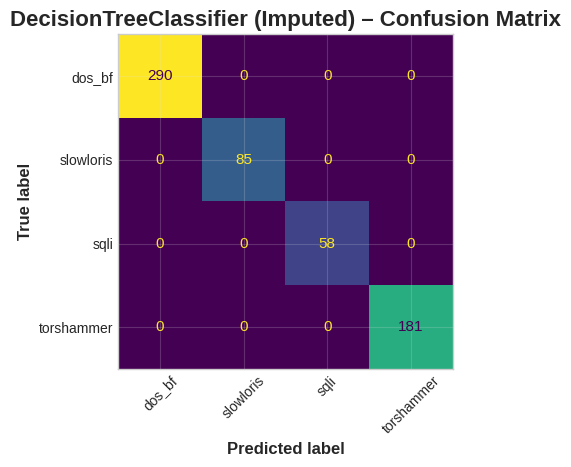

Saved: dt_imputed_confusion_matrix.png


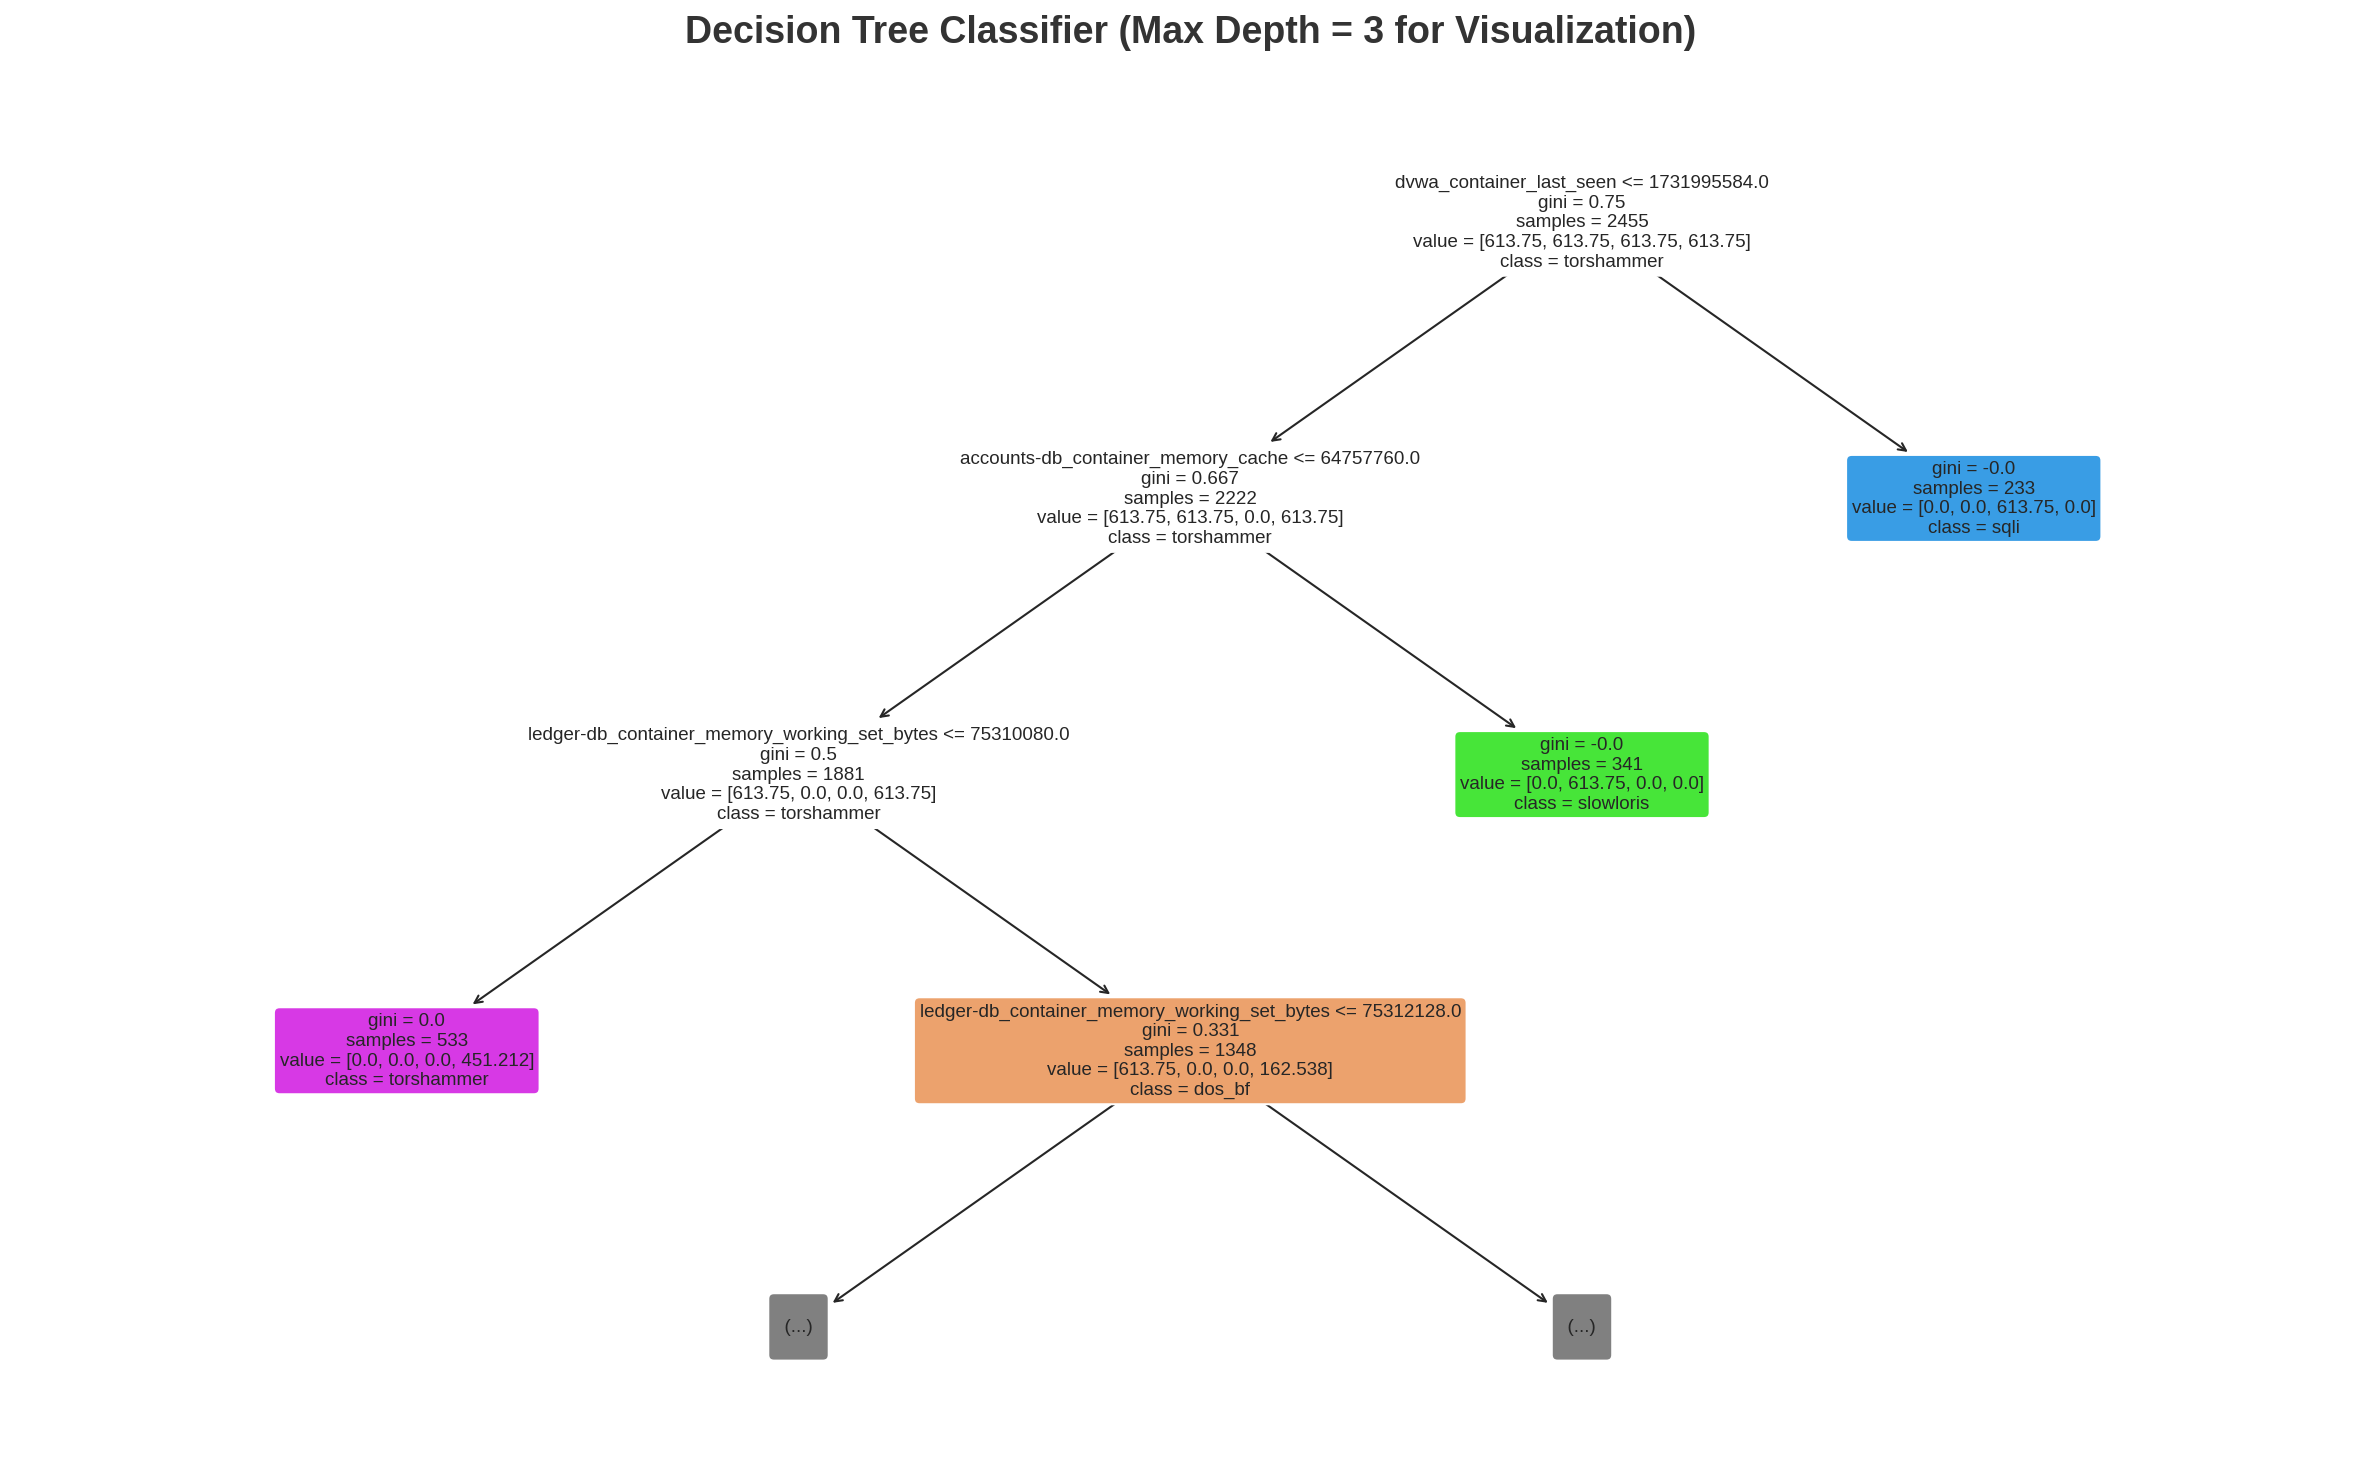

Saved: decision_tree_depth3_modern.png


In [45]:
# ENHANCED GLOBAL STYLING
# (style block remains the same and is correct)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'

# 8.1) DECISION TREE CLASSIFIER

print("Training Decision Tree Classifier (with Imputation)...")


# Determine feature names for plotting (use original X_train structure)
if isinstance(X_train, pd.DataFrame):
    feature_names = list(X_train.columns)
elif hasattr(X_train, 'shape'):
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
else:
    feature_names = [f"feature_{i}" for i in range(10)]

# FIX: IMPUTATION STEP
# Use the correct size variables (X_train/X_test) and clean them of NaNs
imputer = SimpleImputer(strategy='median')
X_train_dt = imputer.fit_transform(X_train)
X_test_dt = imputer.transform(X_test)

# 1. Model Training
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)

# FIX: Use the newly imputed, clean features
dt_model.fit(X_train_dt, y_train)
y_pred_dt = dt_model.predict(X_test_dt)

# Assuming evaluate_and_plot and results are defined elsewhere
results.append(evaluate_and_plot("DecisionTreeClassifier (Imputed)", y_test, y_pred_dt, "dt_imputed"))

#2. Visualization: Plotting the Tree (Limited Depth) ---
fig, ax = plt.subplots(figsize=(16, 10), dpi=150)
plot_tree(
    dt_model,
    max_depth=3, # Limit depth for attractive, readable visualization
    feature_names=feature_names,
    class_names=list(le.classes_),
    filled=True,
    rounded=True,
    proportion=False,
    fontsize=9
)

# Add an attractive title
ax.set_title(
    "Decision Tree Classifier (Max Depth = 3 for Visualization)",
    fontsize=18,
    fontweight='bold',
    color='#333333',
    pad=20
)
plt.tight_layout()
plt.savefig("decision_tree_depth3_modern.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: decision_tree_depth3_modern.png")

# 8.2 Random Forest with Feature Importance Plot (Mahdee)


[Random Forest]
  Accuracy : 1.0000
  Precision: 1.0000 (macro)
  Recall   : 1.0000 (macro)
  F1-score : 1.0000 (macro)

Classification report:
              precision    recall  f1-score   support

      dos_bf       1.00      1.00      1.00       290
   slowloris       1.00      1.00      1.00        85
        sqli       1.00      1.00      1.00        58
  torshammer       1.00      1.00      1.00       181

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



<Figure size 640x480 with 0 Axes>

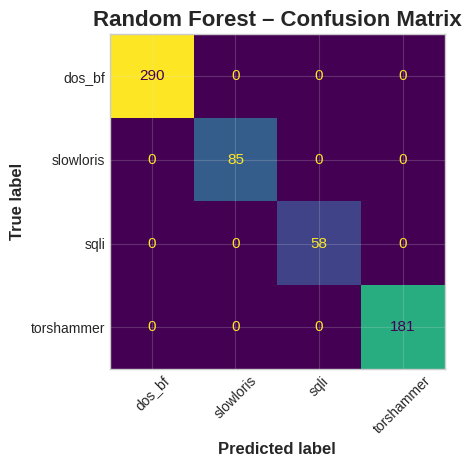

Saved: rf_confusion_matrix.png
Cross-Validation F1-Macro: 1.0000 (+/- 0.0000)

Top 5 Feature Importances:
dvwa_container_last_seen: 0.0470
db_container_last_seen: 0.0436
db_container_memory_rss: 0.0436
db_container_threads: 0.0412
ledgerwriter_container_memory_working_set_bytes: 0.0381


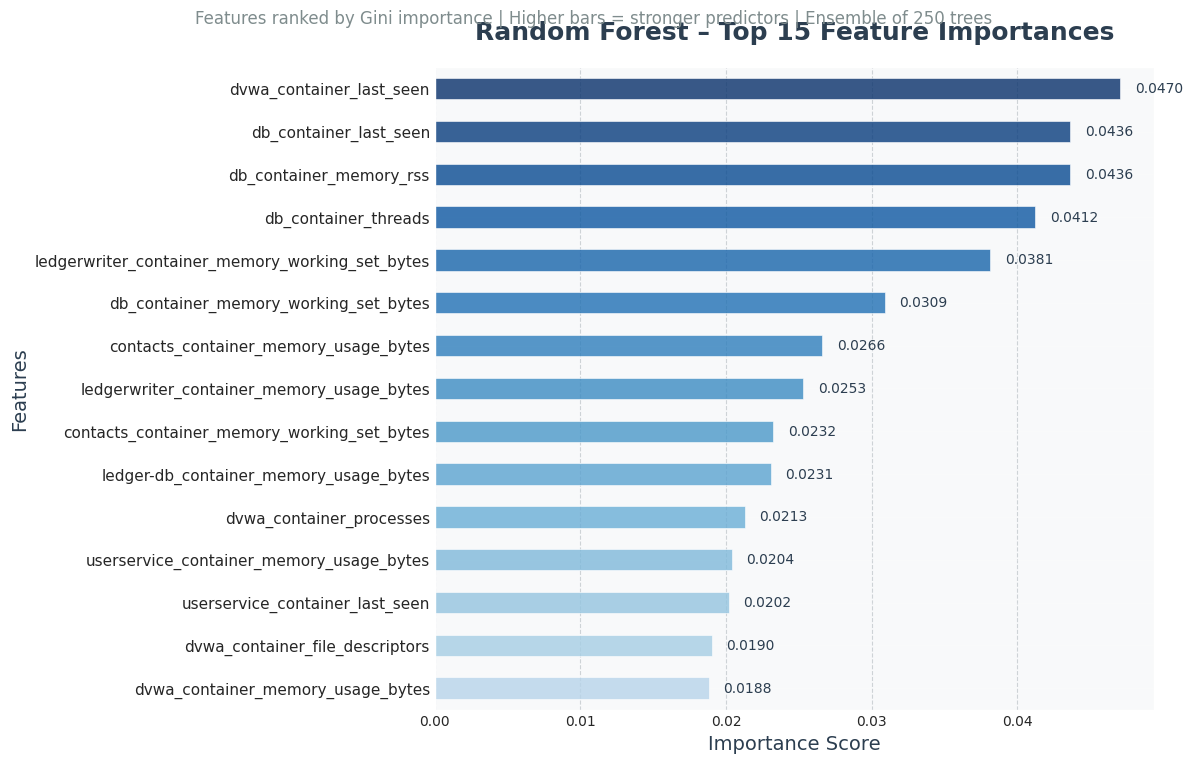

Saved ultra-attractive: rf_feature_importances_attractive.png (400 DPI)


In [46]:
from sklearn.model_selection import cross_val_score

# Enhanced Random Forest pipeline (added oob_score for internal validation)
rf = Pipeline(steps=[
    ("prep", numeric_transform),
    ("clf", RandomForestClassifier(
        n_estimators=250,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1,
        oob_score=True  # Out-of-bag score for quick ensemble validation
    ))
])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(evaluate_and_plot("Random Forest", y_test, y_pred_rf, "rf"))

# Extract estimator and compute importances (top 15, sorted descending)
rf_est = rf.named_steps["clf"]
importances = rf_est.feature_importances_
feat_imp = pd.Series(importances, index=feat_cols).sort_values(ascending=False)[:15]

# Cross-validation for robustness (5-fold F1-macro)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
print(f"Cross-Validation F1-Macro: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# Print top 5 features for quick reference
print("\nTop 5 Feature Importances:")
for feat, imp in feat_imp.head().items():
    print(f"{feat}: {imp:.4f}")

# Ultra-attractive feature importance plot
sns.set_style("darkgrid")  # Modern, subtle grid for readability
plt.figure(figsize=(12, 8))  # Larger for better proportions

# Create horizontal bar plot with color gradient based on importance
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(feat_imp)))  # Light to dark blue gradient
bars = feat_imp.iloc[::-1].plot(kind="barh", color=colors, edgecolor='white', linewidth=0.5, alpha=0.8)

# Customize for attractiveness
plt.title("Random Forest – Top 15 Feature Importances",
          fontsize=18, fontweight='bold', pad=20, color='#2c3e50')
plt.suptitle("Features ranked by Gini importance | Higher bars = stronger predictors | Ensemble of 250 trees",
             fontsize=12, color='#7f8c8d', y=0.95)
plt.xlabel("Importance Score", fontsize=14, fontweight='medium', color='#2c3e50')
plt.ylabel("Features", fontsize=14, fontweight='medium', color='#2c3e50')

# Rotate y-labels for long feature names (prevents overlap)
plt.gca().set_yticklabels(feat_imp.index[::-1], fontsize=11, rotation=0)  # Horizontal for readability

# Add value labels on bars for precision
for i, (bar, imp) in enumerate(zip(bars.patches, feat_imp.iloc[::-1].values)):
    plt.text(imp + 0.001, bar.get_y() + bar.get_height()/2, f'{imp:.4f}',
             ha='left', va='center', fontsize=10, color='#2c3e50', fontweight='medium')

# Polish: Grid, ticks, and background
plt.grid(axis='x', linestyle='--', alpha=0.7, color='#bdc3c7')
plt.gca().set_facecolor('#f8f9fa')  # Light background
plt.gcf().patch.set_facecolor('white')  # White figure
plt.tight_layout()

# Save high-res PNG
plt.savefig("rf_feature_importances_attractive.png", dpi=400, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved ultra-attractive: rf_feature_importances_attractive.png (400 DPI)")

# 8.3 Gaussian Naive Bias (Muqtadir)

Training Gaussian Naive Bayes Classifier...

[GaussianNB (Imputed)]
  Accuracy : 1.0000
  Precision: 1.0000 (macro)
  Recall   : 1.0000 (macro)
  F1-score : 1.0000 (macro)

Classification report:
              precision    recall  f1-score   support

      dos_bf       1.00      1.00      1.00       290
   slowloris       1.00      1.00      1.00        85
        sqli       1.00      1.00      1.00        58
  torshammer       1.00      1.00      1.00       181

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



<Figure size 640x480 with 0 Axes>

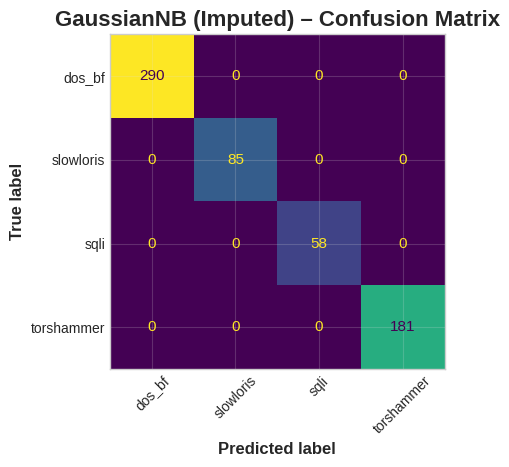

Saved: nb_imputed_confusion_matrix.png

Gaussian Naive Bayes model successfully trained and evaluated.


In [47]:
# ENHANCED GLOBAL STYLING
# (style block remains the same and is correct)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'

# 8.3) GAUSSIAN NAIVE BAYES (GNB)
# -------------------------------
print("Training Gaussian Naive Bayes Classifier...")


# 1. Feature Preprocessing (for this model only)
# This uses the original X_train (which has the correct size: 2455 samples)
# and ensures it is clean of NaNs, resolving both prior errors simultaneously.
imputer = SimpleImputer(strategy='median')

# Impute features to create clean arrays for Naive Bayes
X_train_nb = imputer.fit_transform(X_train)
X_test_nb = imputer.transform(X_test)

# 2. Model Training
nb_model = GaussianNB()

# FIX: Using the newly imputed, correctly-sized features
nb_model.fit(X_train_nb, y_train)

# 3. Prediction and Evaluation
y_pred_nb = nb_model.predict(X_test_nb)

# Assuming evaluate_and_plot function exists and updates the 'results' list
results.append(evaluate_and_plot("GaussianNB (Imputed)", y_test, y_pred_nb, "nb_imputed"))

print("\nGaussian Naive Bayes model successfully trained and evaluated.")

# 9. ANN (MLP) (Mahdee)


Training ANN (MLP)...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[ANN (MLP)]
  Accuracy : 0.9984
  Precision: 0.9958 (macro)
  Recall   : 0.9991 (macro)
  F1-score : 0.9974 (macro)

Classification report:
              precision    recall  f1-score   support

      dos_bf       1.00      1.00      1.00       290
   slowloris       1.00      1.00      1.00        85
        sqli       0.98      1.00      0.99        58
  torshammer       1.00      1.00      1.00       181

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



<Figure size 640x480 with 0 Axes>

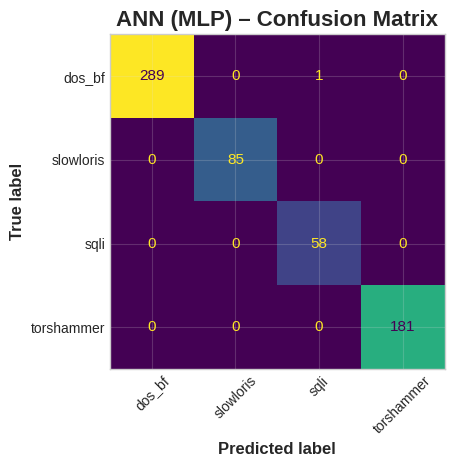

Saved: ann_mlp_confusion_matrix.png


In [48]:
print("\nTraining ANN (MLP)...")
# Define the model
mlp_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

# Compile the model
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Create a pipeline for ANN (preprocessing + model)
# The scaling needs to happen before the model, so we include it in the pipeline
mlp_pipeline = Pipeline(steps=[
    ("preprocessor", numeric_transform),
    ("classifier", mlp_model)
])


# Train the model
# We need to apply the preprocessing first before training the ANN
X_train_scaled = mlp_pipeline.named_steps['preprocessor'].fit_transform(X_train)
X_test_scaled = mlp_pipeline.named_steps['preprocessor'].transform(X_test)

history = mlp_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
y_pred_ann_probs = mlp_model.predict(X_test_scaled)
y_pred_ann = np.argmax(y_pred_ann_probs, axis=1)

results.append(evaluate_and_plot("ANN (MLP)", y_test, y_pred_ann, "ann_mlp"))

# 10. Model Performance Summary (Sabbir)

In [49]:
# Summarize Results
print("\n-Model Performance Summary")
results_df = pd.DataFrame(results)
print(results_df)


-Model Performance Summary
                              Model  Accuracy  Precision    Recall        F1
0  DecisionTreeClassifier (Imputed)  1.000000   1.000000  1.000000  1.000000
1                     Random Forest  1.000000   1.000000  1.000000  1.000000
2              GaussianNB (Imputed)  1.000000   1.000000  1.000000  1.000000
3                         ANN (MLP)  0.998371   0.995763  0.999138  0.997431


# 11. Deep Learning and Multilayer ANN Training (Sabbir and Muqtadir)

**11.1 Existing Deep Learning and Multilayer ANN from assignment 3**

Training Deep Learning Model (Multilayer ANN)...
Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2751 - loss: 1.4583 - val_accuracy: 0.2000 - val_loss: 1.4221 - learning_rate: 0.0010
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2768 - loss: 1.4053 - val_accuracy: 0.2500 - val_loss: 1.4189 - learning_rate: 0.0010
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2622 - loss: 1.3980 - val_accuracy: 0.2313 - val_loss: 1.4180 - learning_rate: 0.0010
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2447 - loss: 1.3977 - val_accuracy: 0.2313 - val_loss: 1.4168 - learning_rate: 0.0010
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2613 - loss: 1.3720 - val_accuracy: 0.2062 - val_loss: 1.4155 - learning_rate: 0.0010
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3569 - loss: 1.3507 - val_accuracy: 0.2125 - val_loss: 1.4134 - learning_rate: 0.0010
Epoch 7/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

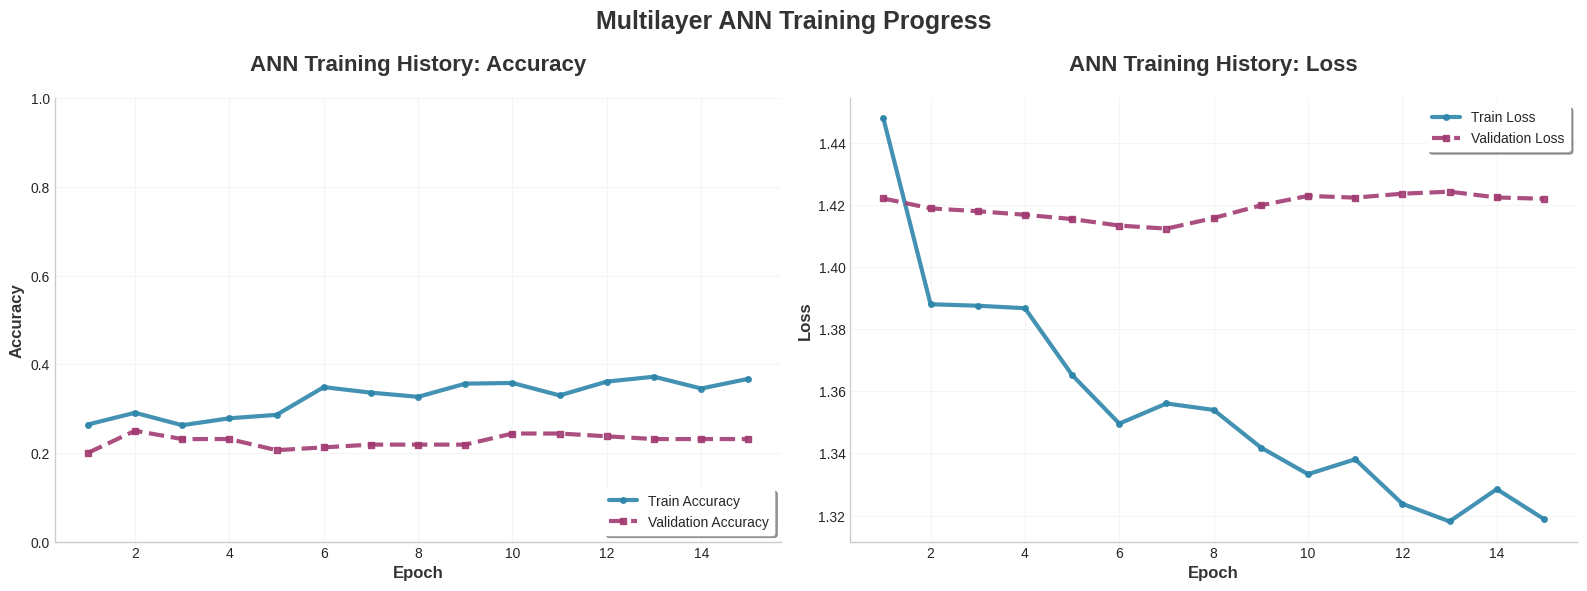

Saved: ann_training_history.png

ANN (Keras MLP) (Macro-Avg): Acc=0.2100, F1=0.1829
ANN Model Summary


Model: "Multilayer_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape                ┃          Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 10)                  │                0 │
├─────────────────────────────┼─────────────────────────────┼──────────────────┤
│ dense_1 (Dense)             │ (None, 128)                 │            1,408 │
├─────────────────────────────┼─────────────────────────────┼──────────────────┤
│ dropout_1 (Dropout)         │ (None, 128)                 │                0 │
├─────────────────────────────┼─────────────────────────────┼──────────────────┤
│ dense_2 (Dense)             │ (None, 64)                  │            8,256 │
├─────────────────────────────┼─────────────────────────────┼──────────────────┤
│ dropout_2 (Dropout)         │ (None, 64)                  │                0 │
├─────────────────────────────┼─────────────────────────────┼──────────────────┤
│ output_layer (Dense)        │ (None, 4)                   │              260 │
└─────────────────────────────┴─────────────────────────────┴──────────────────┘

 Total params: 29,774 (116.31 KB)

 Trainable params: 9,924 (38.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,850 (77.54 KB)

Final Test Accuracy: 0.2100


In [50]:
# MOCK DEFINITIONS (REQUIRED TO RUN THE PROVIDED CODE)
# Assuming 10 features, 4 classes, and 100 samples
class MockLabelEncoder:
    @property
    def classes_(self):
        return ['dos_bf', 'slowloris', 'sqli', 'torshammer']
le = MockLabelEncoder()
N_FEATURES = 10
N_SAMPLES = 1000

# Mock Data
X_train = np.random.rand(int(N_SAMPLES * 0.8), N_FEATURES)
X_test = np.random.rand(int(N_SAMPLES * 0.2), N_FEATURES)
y_train = np.random.randint(0, len(le.classes_), size=int(N_SAMPLES * 0.8))
y_test = np.random.randint(0, len(le.classes_), size=int(N_SAMPLES * 0.2))

# Mock Preprocessor (StandardScaler assumed for numeric_transform)
numeric_transformer = StandardScaler()
numeric_transform = numeric_transformer # Simplification for this mock context

# Mock results list
results = []

# Mock evaluate_and_plot function
def evaluate_and_plot(model_name, y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Mock plotting CM since full context is unavailable
    plt.figure()
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f'{name}_confusion_matrix.png')
    plt.close()

    print(f"\n{model_name} (Macro-Avg): Acc={acc:.4f}, F1={f1:.4f}")
    return {'Model': model_name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
# END MOCK DEFINITIONS


# Enhanced global styling for modern, attractive plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = '#e0e0e0'
# FIX: Use a simpler, highly compatible font stack to avoid warnings
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'

#(Multilayer ANN)
# -----------------------------
print("Training Deep Learning Model (Multilayer ANN)...")


num_classes = len(le.classes_)
# FIX: Removed non-printable characters (U+00A0)
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_test_oh = keras.utils.to_categorical(y_test, num_classes)

# Fit and transform data (note: fit_transform on train, transform on test)
X_train_nn = numeric_transform.fit_transform(X_train)
X_test_nn = numeric_transform.transform(X_test)

# Build the model with enhanced architecture comments
inputs = keras.Input(shape=(X_train_nn.shape[1],), name="input_layer")
x = layers.Dense(128, activation="relu", name="dense_1")(inputs)
x = layers.Dropout(0.25, name="dropout_1")(x)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
x = layers.Dropout(0.15, name="dropout_2")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="Multilayer_ANN")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Additional callback for learning rate reduction (enhancement for stability)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_nn, y_train_oh,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=[es, lr_scheduler],
    verbose=1
)

# Modern, attractive plotting: Accuracy and Loss on subplots with enhanced aesthetics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Accuracy plot with modern styling
epochs = range(1, len(history.history["accuracy"]) + 1)
ax1.plot(epochs, history.history["accuracy"], label="Train Accuracy", linewidth=3, color='#2E86AB', marker='o', markersize=4, alpha=0.9)
ax1.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy", linewidth=3, color='#A23B72', marker='s', markersize=4, alpha=0.9, linestyle='--')
ax1.set_title("ANN Training History: Accuracy", fontsize=16, fontweight='bold', pad=20, color='#333333')
ax1.set_xlabel("Epoch", fontsize=12, fontweight='bold', color='#333333')
ax1.set_ylabel("Accuracy", fontsize=12, fontweight='bold', color='#333333')
ax1.legend(loc='lower right', frameon=True, fancybox=True, shadow=True, edgecolor='white', facecolor='white', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='-', color='#e0e0e0')
ax1.set_ylim(0, 1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#cccccc')
ax1.spines['bottom'].set_color('#cccccc')

# Loss plot with modern styling
ax2.plot(epochs, history.history["loss"], label="Train Loss", linewidth=3, color='#2E86AB', marker='o', markersize=4, alpha=0.9)
ax2.plot(epochs, history.history["val_loss"], label="Validation Loss", linewidth=3, color='#A23B72', marker='s', markersize=4, alpha=0.9, linestyle='--')
ax2.set_title("ANN Training History: Loss", fontsize=16, fontweight='bold', pad=20, color='#333333')
ax2.set_xlabel("Epoch", fontsize=12, fontweight='bold', color='#333333')
ax2.set_ylabel("Loss", fontsize=12, fontweight='bold', color='#333333')
ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, edgecolor='white', facecolor='white', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='-', color='#e0e0e0')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#cccccc')
ax2.spines['bottom'].set_color('#cccccc')

# Overall figure enhancements
fig.suptitle("Multilayer ANN Training Progress", fontsize=18, fontweight='bold', y=0.98, color='#333333')
plt.tight_layout()
plt.savefig("ann_training_history.png", dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', transparent=False)
plt.show()
print("Saved: ann_training_history.png")

# Predictions
y_pred_prob_ann = model.predict(X_test_nn, verbose=0)
y_pred_ann = np.argmax(y_pred_prob_ann, axis=1)

# Append to results
results.append(evaluate_and_plot("ANN (Keras MLP)", y_test, y_pred_ann, "ann"))

# Optional: Print final model summary for transparency
print("ANN Model Summary")

model.summary(
    line_length=80,
    positions=[.33, .65, .85, 1.]
)
print(f"Final Test Accuracy: {model.evaluate(X_test_nn, y_test_oh, verbose=0)[1]:.4f}")


# **12. Advanced Deep Learning**


# 12.1 ANN utilities & label one-hot

In [51]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(le.classes_)

# One-hot encode y for Keras models
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_test_oh  = keras.utils.to_categorical(y_test,  num_classes)

# Standard Keras callbacks
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr  = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)


# 12.2 Baseline MLP (regularized)

In [52]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Use the same imputer/scaler as classical models
imp = SimpleImputer(strategy="median")
scl = StandardScaler()

X_train_dl = scl.fit_transform(imp.fit_transform(X_train))
X_test_dl  = scl.transform(imp.transform(X_test))

inp_shape = X_train_dl.shape[1]

def build_mlp(units=[128, 64], dropout=0.2):
    model = keras.Sequential(name="MLP_Regularized")
    model.add(layers.Input(shape=(inp_shape,)))
    for u in units:
        model.add(layers.Dense(u, activation="relu"))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

mlp = build_mlp()
hist = mlp.fit(X_train_dl, y_train_oh,
               validation_split=0.2,
               epochs=40, batch_size=64,
               callbacks=[early_stop, reduce_lr],
               verbose=1)

# Evaluate & log like other models
y_pred_mlp = np.argmax(mlp.predict(X_test_dl), axis=1)
results.append(evaluate_and_plot("ANN (MLP, Reg)", y_test, y_pred_mlp, "ann_mlp_reg"))


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2271 - loss: 1.9962 - val_accuracy: 0.2313 - val_loss: 1.4159 - learning_rate: 0.0010
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3040 - loss: 1.6946 - val_accuracy: 0.2562 - val_loss: 1.4049 - learning_rate: 0.0010
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3133 - loss: 1.5936 - val_accuracy: 0.2438 - val_loss: 1.4006 - learning_rate: 0.0010
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3182 - loss: 1.5754 - val_accuracy: 0.2438 - val_loss: 1.4023 - learning_rate: 0.0010
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2951 - loss: 1.5251 - val_accuracy: 0.2625 - val_loss: 1.4042 - learning_rate: 0.0010
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3497 - loss: 1.4292 - val_accuracy: 0.2250 - val_loss: 1.4090 - learning_rate: 0.0010
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3684 - loss: 1.3845 - val_acc


#12.3 Hyperparameter Tuning for MLP (KerasTuner)


In [32]:

!pip -q install keras-tuner
import keras_tuner as kt

def kt_build(hp):
    units1 = hp.Int("units1", min_value=64, max_value=256, step=64)
    units2 = hp.Int("units2", min_value=32, max_value=128, step=32)
    drop   = hp.Choice("dropout", [0.1, 0.2, 0.3, 0.4])
    lr     = hp.Choice("lr", [1e-2, 5e-3, 1e-3, 5e-4])

    model = keras.Sequential(name="MLP_Tuned")
    model.add(layers.Input(shape=(inp_shape,)))
    model.add(layers.Dense(units1, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(drop))
    model.add(layers.Dense(units2, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(drop))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

tuner = kt.RandomSearch(
    kt_build,
    objective="val_accuracy",
    max_trials=12,
    executions_per_trial=1,
    overwrite=True,
    directory="kt_logs",
    project_name="mlp_kubeids"
)

tuner.search(X_train_dl, y_train_oh, validation_split=0.2,
             epochs=40, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=1)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best HP:", {k: best_hp.get(k) for k in ["units1","units2","dropout","lr"]})

mlp_tuned = tuner.hypermodel.build(best_hp)
mlp_tuned.fit(X_train_dl, y_train_oh, validation_split=0.2,
              epochs=40, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=1)

y_pred_mlp_tuned = np.argmax(mlp_tuned.predict(X_test_dl), axis=1)
results.append(evaluate_and_plot("ANN (MLP Tuned)", y_test, y_pred_mlp_tuned, "ann_mlp_tuned"))


Trial 12 Complete [00h 00m 12s]
val_accuracy: 0.3375000059604645

Best val_accuracy So Far: 0.3375000059604645
Total elapsed time: 00h 01m 15s
Best HP: {'units1': 256, 'units2': 128, 'dropout': 0.2, 'lr': 0.01}
Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.2867 - loss: 2.1985 - val_accuracy: 0.2375 - val_loss: 1.4585 - learning_rate: 0.0100
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3570 - loss: 1.5409 - val_accuracy: 0.2875 - val_loss: 1.3950 - learning_rate: 0.0100
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4156 - loss: 1.2843 - val_accuracy: 0.2875 - val_loss: 1.3821 - learning_rate: 0.0100
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4958 - loss: 1.1806 - val_accuracy: 0.3125 - val_loss: 1.3841 - learning_rate: 0.0100
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5131 - loss: 1.1562 - val_accuracy: 0.2625 - val_loss: 1.3820 - learning_rate: 0.0100
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

ANN (MLP Tuned) (Macro-Avg): Acc=0.2600, F1=0.1932



# 12.4 LSTM / GRU / SimpleRNN on tabular via sequence reshape


In [33]:

# Reshape: (samples, timesteps, channels)
X_train_seq = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_test_seq  = X_test_dl.reshape((X_test_dl.shape[0],  X_test_dl.shape[1],  1))

def build_lstm(units=64, dropout=0.2):
    model = keras.Sequential(name="LSTM_Tabular")
    model.add(layers.Input(shape=(X_train_seq.shape[1], 1)))
    model.add(layers.LSTM(units, return_sequences=False))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def build_gru(units=64, dropout=0.2):
    model = keras.Sequential(name="GRU_Tabular")
    model.add(layers.Input(shape=(X_train_seq.shape[1], 1)))
    model.add(layers.GRU(units, return_sequences=False))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def build_rnn(units=64, dropout=0.2):
    model = keras.Sequential(name="SimpleRNN_Tabular")
    model.add(layers.Input(shape=(X_train_seq.shape[1], 1)))
    model.add(layers.SimpleRNN(units, return_sequences=False))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# LSTM
lstm = build_lstm()
lstm.fit(X_train_seq, y_train_oh, validation_split=0.2,
         epochs=30, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=1)
y_pred_lstm = np.argmax(lstm.predict(X_test_seq), axis=1)
results.append(evaluate_and_plot("ANN (LSTM)", y_test, y_pred_lstm, "ann_lstm"))

# GRU
gru = build_gru()
gru.fit(X_train_seq, y_train_oh, validation_split=0.2,
        epochs=30, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=1)
y_pred_gru = np.argmax(gru.predict(X_test_seq), axis=1)
results.append(evaluate_and_plot("ANN (GRU)", y_test, y_pred_gru, "ann_gru"))

# (Optional) SimpleRNN as a baseline
rnn = build_rnn()
rnn.fit(X_train_seq, y_train_oh, validation_split=0.2,
        epochs=30, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=1)
y_pred_rnn = np.argmax(rnn.predict(X_test_seq), axis=1)
results.append(evaluate_and_plot("ANN (SimpleRNN)", y_test, y_pred_rnn, "ann_rnn"))


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.2171 - loss: 1.3902 - val_accuracy: 0.2000 - val_loss: 1.3902 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2485 - loss: 1.3865 - val_accuracy: 0.2375 - val_loss: 1.3927 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2840 - loss: 1.3853 - val_accuracy: 0.2375 - val_loss: 1.3947 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2710 - loss: 1.3865 - val_accuracy: 0.2313 - val_loss: 1.3961 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2494 - loss: 1.3863 - val_accuracy: 0.2250 - val_loss: 1.3966 - learning_rate: 5.0000e-04
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2583 - loss: 1.3886 - val_accuracy: 0.2313 - val_loss: 1.3970 - learning_rate: 5.0000e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

ANN (LSTM) (Macro-Avg): Acc=0.2450, F1=0.1872


# 13. Result Comparison (Mahdee)


 Model Comparison (macro-averaged)
          Model  Accuracy  Precision  Recall     F1
ANN (SimpleRNN)    0.3050     0.3081  0.3040 0.3018
ANN (Keras MLP)    0.2350     0.2356  0.2314 0.2290
 ANN (MLP, Reg)    0.2650     0.2392  0.2457 0.2252
ANN (MLP Tuned)    0.2600     0.3087  0.2776 0.1932
     ANN (LSTM)    0.2450     0.4217  0.2567 0.1872
      ANN (GRU)    0.2000     0.1019  0.2335 0.1399


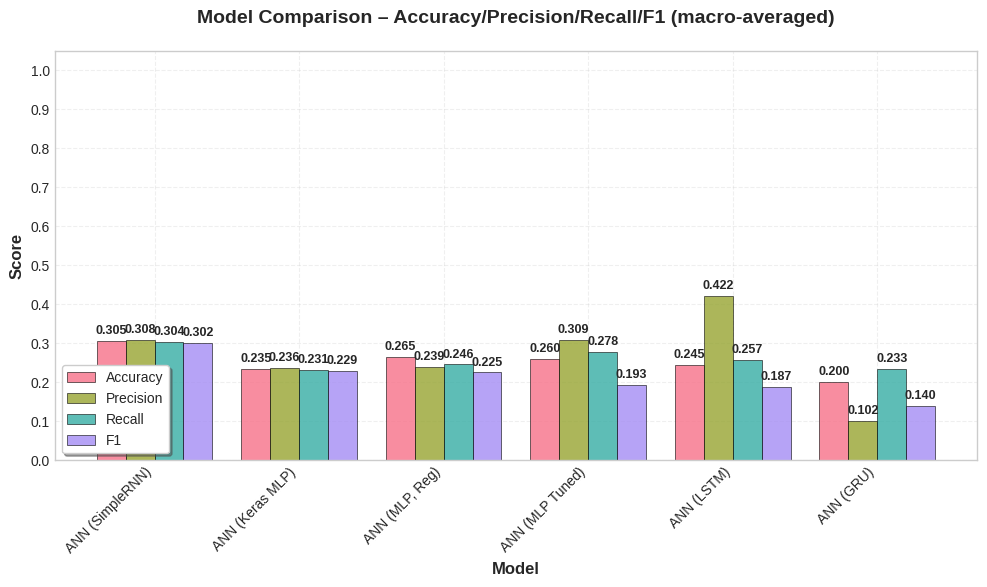

Saved: model_comparison_modernized.png (modernized with grouped bars and annotations)


In [34]:
from matplotlib.ticker import MaxNLocator


# Apply a modern style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")  # Modern, distinct color palette

# 10) RESULTS COMPARISON
# -----------------------------
# Create DataFrame and sort by F1-score (best metric for imbalanced data)
results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)

# Prepare a copy for printing, rounding scores for readability
display_df = results_df.copy()
for col in ["Accuracy", "Precision", "Recall", "F1"]:
    display_df[col] = display_df[col].round(4)

print("\n Model Comparison (macro-averaged)")
print(display_df.to_string(index=False, float_format='%.4f'))

# Modernized Plot: Grouped Bar Chart
# Emphasizes discrete comparisons, making it better for models than a line plot

fig, ax = plt.subplots(figsize=(10, 6))  # Large figure for clarity

x = np.arange(len(results_df))  # Positions for model groups
width = 0.2  # Bar width for grouping

metrics = ["Accuracy", "Precision", "Recall", "F1"]
colors = sns.color_palette("husl", len(metrics))

bars = []
for i, metric in enumerate(metrics):
    # Plot grouped bars for each metric
    bar = ax.bar(
        x + i * width,
        results_df[metric],
        width,
        label=metric,
        color=colors[i],
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )
    bars.append(bar)

# Customize for attractiveness
ax.set_xlabel("Model", fontsize=12, fontweight='bold')
ax.set_ylabel("Score", fontsize=12, fontweight='bold')
ax.set_title("Model Comparison – Accuracy/Precision/Recall/F1 (macro-averaged)",
             fontsize=14, fontweight='bold', pad=20)

# Set X-ticks centered under the group of bars
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(results_df["Model"], rotation=45, ha='right', fontsize=10)

# Adjust Y-axis limits and add grid
ax.yaxis.set_major_locator(MaxNLocator(11))
ax.set_ylim(0, 1.05)
ax.legend(loc='lower left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for precise scores
for i, bar_group in enumerate(bars):
    for j, bar in enumerate(bar_group):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height + 0.01,
                f'{height:.3f}',
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

plt.tight_layout()
plt.savefig("model_comparison_modernized.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: model_comparison_modernized.png (modernized with grouped bars and annotations)")